<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/object_localization_vegetable_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Localization**

In this project, we will develop a model to locate an instance of a particular object category in an image. We will use a small vegetable dataset and assume that there is just one vegetable in any given image. Our CNN model will classify and localize (plot a bounding box) the object.

The process will be broken down into the following steps:

  1.   Load and visualiza the data
  2.   Define a neural network
  3.   Train the model
  4.   Evaluate the performance of our trained model on a test dataset!



## Load and visualize the data

In [1]:
# download the dataset
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 11.76 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
# install albumentations and timm (these two libraries are not installed in colab)
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-tgfcujjg
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-tgfcujjg
     |████████████████████████████████| 47.8 MB 1.8 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=5551fcd5a6036895b825ad9a98590ce372bd1e5d48dd4269d1b66532f8ff9cad
  Stored in directory: /tmp/pip-ephem-wheel-cache-l2omvu2y/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 431 kB 4.3 MB/s 


In [3]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [4]:
# import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
import sys
sys.path.append("/content/object-localization-dataset")

In [7]:
data_dir = "/content/object-localization-dataset/" 
df = pd.read_csv(data_dir + "train.csv")
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


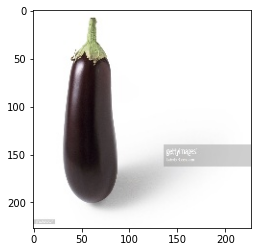

In [8]:
# visualize an image
image = df.iloc[1]
img = cv2.imread(data_dir + image.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

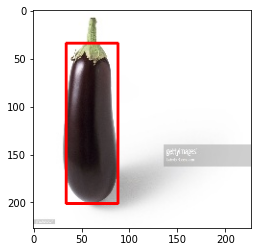

In [9]:
# visualize an image with bounding box
pt1 = (image.xmin, image.ymin)
pt2 = (image.xmax, image.ymax)
b_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0),2)
plt.imshow(b_box_img)

In [10]:
# split the dataset into train and validation datasets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
# augment some data using albumentations package
import albumentations as A

data_aug_train = A.Compose([A.Resize(140, 140),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.Rotate()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

data_aug_val = A.Compose([A.Resize(140, 140),], 
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [12]:
# create custom dataset
class ObjLocData(torch.utils.data.Dataset):
  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      image = self.df.iloc[idx]
      xmin = image.xmin
      ymin = image.ymin
      xmax = image.xmax
      ymax = image.ymax

      bbox = [[xmin, ymin, xmax, ymax]]

      image_path = data_dir + image.img_path
      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      if self.augmentations:
        data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
        img = data['image']
        bbox = data['bboxes'][0]

      img = torch.from_numpy(img).permute(2,0,1)/255.0 # (h,w,c) -> (c,h,w)
      bbox = torch.Tensor(bbox)

      return img, bbox

In [13]:
train_data = ObjLocData(train_df, data_aug_train)
val_data = ObjLocData(val_df, data_aug_val)

print('Num training images: ', len(train_data))
print('Num test images: ', len(val_data))

Num training images:  148
Num test images:  38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


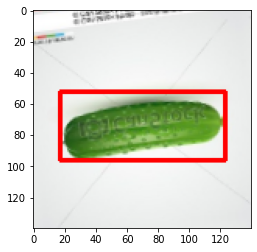

In [14]:
img, bbox = train_data[10]
xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255,0,0),2)
plt.imshow(bnd_img)

In [15]:
# prepare data loaders (combine dataset and sampler)
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

print("Number of batches in train loader: ", len(train_loader))
print("Number of batches in valid loader: ", len(val_loader))

Number of batches in train loader:  10
Number of batches in valid loader:  3


In [16]:
for imges, bboxes in train_loader:
  break
print("Shape of a batch of images: ", imges.shape)
print("Shape of a batch of bboxes: ", bboxes.shape)

Shape of a batch of images:  torch.Size([16, 3, 140, 140])
Shape of a batch of bboxes:  torch.Size([16, 4])


## Define a neural network

In [17]:
from torch import nn
import timm

class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4) # (num_class=4 bacause we want outputs xmin, ymin, xmax, ymax)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

In [18]:
MODEL_NAME = "resnet34"

model = ObjLocModel()
model.cuda()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


ObjLocModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

## Train the model

In [19]:
import torch.optim as optim

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# number of epochs to train the model
n_epochs = 35

val_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    val_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
          images, gt_bboxes = data
          images, gt_bboxes = images.cuda(), gt_bboxes.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        bboxes, loss = model(images, gt_bboxes)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()

    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      for data in tqdm(val_loader):
          # move tensors to GPU if CUDA is available
          images, gt_bboxes = data
          images, gt_bboxes = images.cuda(), gt_bboxes.cuda()
          # forward pass: compute predicted outputs by passing inputs to the model
          bboxes, loss = model(images, gt_bboxes)
          # update average validation loss 
          val_loss += loss.item()

    # calculate average losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, val_loss))
    
    # save model if validation loss has decreased
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        val_loss_min,
        val_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        val_loss_min = val_loss

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 7036.018262 	Validation Loss: 1949.670369
Validation loss decreased (inf --> 1949.670369).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 5778.610840 	Validation Loss: 3983.957031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 4441.929492 	Validation Loss: 3988.041423


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 3597.441724 	Validation Loss: 3207.621745


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 2737.491309 	Validation Loss: 1850.143107
Validation loss decreased (1949.670369 --> 1850.143107).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 2041.037427 	Validation Loss: 1223.963826
Validation loss decreased (1850.143107 --> 1223.963826).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1555.620874 	Validation Loss: 1135.174398
Validation loss decreased (1223.963826 --> 1135.174398).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1030.672333 	Validation Loss: 669.310832
Validation loss decreased (1135.174398 --> 669.310832).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 744.603357 	Validation Loss: 542.248474
Validation loss decreased (669.310832 --> 542.248474).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 500.925452 	Validation Loss: 401.220428
Validation loss decreased (542.248474 --> 401.220428).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 420.181833 	Validation Loss: 272.506317
Validation loss decreased (401.220428 --> 272.506317).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 316.007744 	Validation Loss: 454.559845


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 271.537300 	Validation Loss: 694.012858


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 222.127538 	Validation Loss: 433.792877


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 232.320212 	Validation Loss: 258.031087
Validation loss decreased (272.506317 --> 258.031087).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 238.767830 	Validation Loss: 415.970856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 197.341304 	Validation Loss: 250.890188
Validation loss decreased (258.031087 --> 250.890188).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 185.159813 	Validation Loss: 374.829254


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 188.069353 	Validation Loss: 233.068771
Validation loss decreased (250.890188 --> 233.068771).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 164.368571 	Validation Loss: 370.521352


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 191.449393 	Validation Loss: 168.980413
Validation loss decreased (233.068771 --> 168.980413).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 171.179280 	Validation Loss: 205.880722


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 163.517811 	Validation Loss: 490.677856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 155.156711 	Validation Loss: 154.656850
Validation loss decreased (168.980413 --> 154.656850).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 153.051914 	Validation Loss: 404.378286


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 161.259206 	Validation Loss: 177.162816


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 142.744010 	Validation Loss: 288.639084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 147.198595 	Validation Loss: 194.773422


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 146.714197 	Validation Loss: 117.865855
Validation loss decreased (154.656850 --> 117.865855).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 134.277596 	Validation Loss: 157.882116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 136.468202 	Validation Loss: 199.238581


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 113.265179 	Validation Loss: 194.142721


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 146.896995 	Validation Loss: 274.682566


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 123.750216 	Validation Loss: 278.198130


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 118.554090 	Validation Loss: 104.479703
Validation loss decreased (117.865855 --> 104.479703).  Saving model ...


## Evaluate the performance of our trained model on a test dataset!

In [21]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


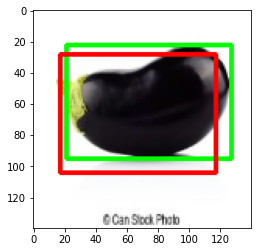

In [22]:
import utils

model.eval()

with torch.no_grad():
  image, gt_bbox = val_data[15]
  image = image.unsqueeze(0).cuda()
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)